# CNN Regression

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm  # Fortschrittsbalken
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Daten laden

data_path = 'data/embedded_padded'
BATCH_SIZE = 32

train_dataset = torch.load(data_path + '/train.pt')
test_dataset = torch.load(data_path + '/test.pt')
val_dataset = torch.load(data_path + '/val.pt')

# DataLoader vorbereiten
def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])  
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.float32).unsqueeze(1)  
    return input_ids, labels

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


/var/folders/l7/061cw0t95vz1myntpf9bj9540000gn/T/ipykernel_46830/3644220936.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(data_path + '/trai

/Users/michellegoppinger/Documents/Dokumente – Laptop von Michelle/Uni/Master/ANLP/ANLP_WS24_CA2/HumorDataset.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  item = {'input_ids': torch.tensor(self.data[idx], dtype=torch.float)}


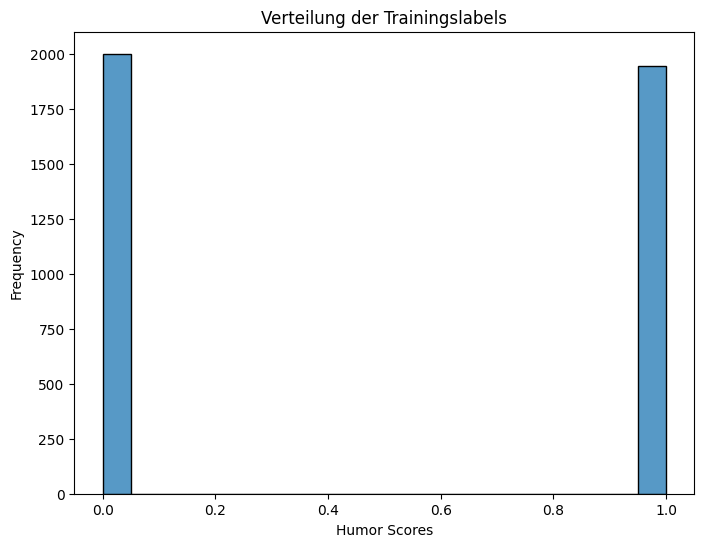

In [3]:
# Labels extrahieren und in eine Liste konvertieren
train_labels = [item["labels"].item() for item in train_dataset]  

# Verteilung der Labels visualisieren
plt.figure(figsize=(8, 6))
sns.histplot(train_labels, bins=20)
plt.xlabel("Humor Scores")
plt.ylabel("Frequency")
plt.title("Verteilung der Trainingslabels")
plt.show()


In [4]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, inputs, targets):
        weights = self.weights[targets.long()]
        loss = weights * (inputs - targets) ** 2
        return loss.mean()

# Gewichtung basierend auf Seltenheit der Zwischenwerte
weights = torch.tensor([2.0 if 0.2 <= x <= 0.8 else 1.0 for x in range(2)], dtype=torch.float32)


In [5]:
class CNN_HumorRegressor(nn.Module):
    def __init__(self, embed_dim, filter_sizes, num_filters, dropout=0.5):
        super(CNN_HumorRegressor, self).__init__()

        # Convolutional Layers mit verschiedenen Filtergrößen
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embed_dim)) 
            for fs in filter_sizes
        ])

        # Highway-Netzwerk für bessere Feature-Extraktion
        self.highway = nn.Linear(len(filter_sizes) * num_filters, len(filter_sizes) * num_filters)

        # Dropout zur Vermeidung von Overfitting
        self.dropout = nn.Dropout(dropout)

        # Fully Connected Layers
        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [Batch Size, 1, Seq Length, Embed Dim]

        # Convolution + ReLU activation
        conved = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        # Max-Pooling über jede Feature-Map
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in conved]

        # Feature-Vektor kombinieren
        cat = torch.cat(pooled, dim=1)

        # Highway-Netzwerk
        highway = F.relu(self.highway(cat))
        highway = self.dropout(highway + cat)

        # Fully Connected Layers
        fc_out = F.relu(self.fc1(highway))
        fc_out = F.relu(self.fc2(fc_out))
        return torch.sigmoid(self.fc3(fc_out))  # Sigmoid für Wertebereich [0, 1]


In [6]:
EMBED_DIM = train_dataset[0]["input_ids"].shape[1]
FILTER_SIZES = [2, 3, 4, 5]
NUM_FILTERS = 300
DROPOUT = 0.5
LR = 0.001
EPOCHS = 10

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Modell initialisieren
model = CNN_HumorRegressor(EMBED_DIM, FILTER_SIZES, NUM_FILTERS, DROPOUT).to(device)

# Gewichtete Verlustfunktion und Optimierer
criterion = WeightedMSELoss(weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Fortschrittsbalken für das Training
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        val_loss = evaluate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss:.4f} - Val Loss: {val_loss:.4f}")

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with tqdm(test_loader, unit="batch", desc="Evaluating") as tepoch:
        with torch.no_grad():
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
    return total_loss / len(test_loader)


In [8]:
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, device)


Epoch 1/10:   0%|          | 0/124 [00:00<?, ?batch/s]

Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.09batch/s]


Epoch 1/10 - Train Loss: 30.5479 - Val Loss: 0.2415


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.36batch/s]


Epoch 2/10 - Train Loss: 27.5358 - Val Loss: 0.2162


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.26batch/s]


Epoch 3/10 - Train Loss: 23.0742 - Val Loss: 0.2215


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.24batch/s]


Epoch 4/10 - Train Loss: 16.9821 - Val Loss: 0.2608


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.43batch/s]


Epoch 5/10 - Train Loss: 10.0560 - Val Loss: 0.2646


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.23batch/s]


Epoch 6/10 - Train Loss: 9.3069 - Val Loss: 0.2535


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.21batch/s]


Epoch 7/10 - Train Loss: 6.4416 - Val Loss: 0.2688


Evaluating: 100%|██████████| 16/16 [00:30<00:00,  1.92s/batch]


Epoch 8/10 - Train Loss: 4.9270 - Val Loss: 0.2915


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.17batch/s]


Epoch 9/10 - Train Loss: 2.8456 - Val Loss: 0.3152


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.12batch/s]

Epoch 10/10 - Train Loss: 2.2282 - Val Loss: 0.2945


In [9]:
test_loss = evaluate(model, test_loader, criterion, device)
print(f"Test Loss (MSE): {test_loss:.4f}")


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.59batch/s]

Test Loss (MSE): 0.3395


In [10]:
def evaluate_metrics(model, test_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy().flatten())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    return mse, rmse, mae, r2, actuals, predictions

mse, rmse, mae, r2, actuals, predictions = evaluate_metrics(model, test_loader, device)

print("Evaluation Metrics on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")



Evaluation Metrics on Test Data:
Mean Squared Error (MSE): 0.3358
Root Mean Squared Error (RMSE): 0.5795
Mean Absolute Error (MAE): 0.3900
R² Score: -0.3445


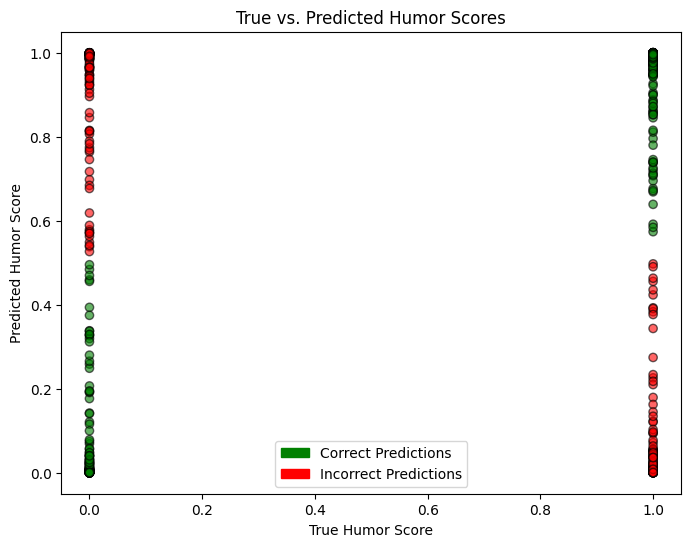

In [14]:
# Definiere korrekte und falsche Vorhersagen basierend auf einem Schwellenwert
threshold = 0.5
predicted_labels = (np.array(predictions) > threshold).astype(int)
true_labels = (np.array(actuals) > threshold).astype(int)

# Bool-Array für korrekte Vorhersagen
correct = predicted_labels == true_labels

# Farben zuordnen: Grün für korrekt, Rot für falsch
colors = ['green' if is_correct else 'red' for is_correct in correct]

# Scatter-Plot
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, c=colors, alpha=0.6, edgecolor='k')


# Legende anpassen
import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='Correct Predictions')
red_patch = mpatches.Patch(color='red', label='Incorrect Predictions')
plt.legend(handles=[green_patch, red_patch])

# Achsen und Titel
plt.title('True vs. Predicted Humor Scores')
plt.xlabel('True Humor Score')
plt.ylabel('Predicted Humor Score')
plt.show()


239


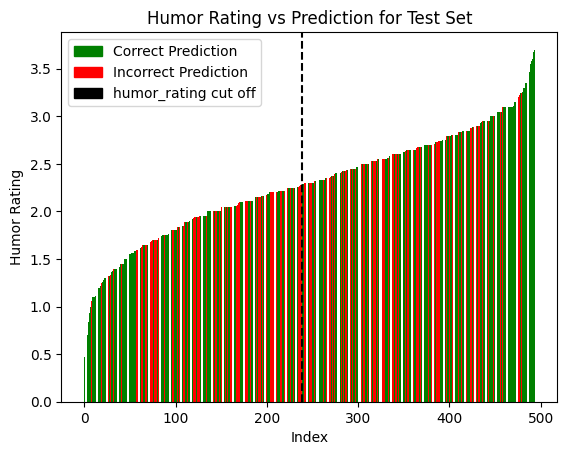

In [15]:
import pandas as pd

# Load the data from csv
df = pd.read_csv('data/hack.csv')
df_test = df.iloc[test_dataset.original_indices].copy()
df_test['prediction'] = predicted_labels
df_test['label'] = true_labels
df_test['pred_correct'] = (df_test['prediction'] == df_test['label'])

df_test_sorted = df_test.sort_values(by='humor_rating').reset_index(drop=True)

from matplotlib import patches as mpatches

median_rating = df['humor_rating'].median()
# get first index where humor_rating is greater than median_rating
median_idx = df_test_sorted[df_test_sorted['humor_rating'] > median_rating].index[0]
print(median_idx)
# range idx for len df_test
range_idx = range(len(df_test))
colors = df_test_sorted['pred_correct'].map({True: 'g', False: 'r'})
# bar plot for each df_test humor_rating value 
plt.bar(range_idx, df_test_sorted['humor_rating'], color=colors)
# vertical line for True/False cut off
plt.axvline(x=median_idx, color='black', linestyle='--')
# Create a legend handles
green_patch = mpatches.Patch(color='g', label='Correct Prediction')
red_patch = mpatches.Patch(color='r', label='Incorrect Prediction')
line_patch = mpatches.Patch(color='black', label='humor_rating cut off')
plt.title('Humor Rating vs Prediction for Test Set')
plt.xlabel('Index')
plt.ylabel('Humor Rating')
plt.legend(handles=[green_patch, red_patch, line_patch])
plt.show()